In [0]:
!pip install tqdm

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display

from tqdm import tqdm

tf.enable_eager_execution()

## Loading the MNIST dataset

In [0]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


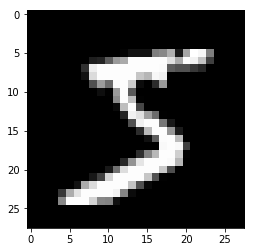

161


In [0]:
plt.imshow(X_train[0,:], cmap='gray')
plt.show()

# check for the pixel range of the dataset
print(np.argmax(X_train[0, :]))

In [0]:
def normalize_images(image):
    image = tf.math.divide(image, 255)
    return image

In [0]:
# reshape the training set to incorporate channel info
X_train = X_train.reshape((60000, 28, 28, 1))

# create a dataset from the numpy arrays
mnist_dataset = tf.data.Dataset.from_tensor_slices(X_train)

# Perform transformations on the dataset like batching and shuffling
batch_size = 128
mnist_dataset = mnist_dataset.map(normalize_images).batch(batch_size)

In [0]:
import math
def display_images(image_batch):
    batch_size = image_batch.shape[0]
    grid_size = math.ceil(math.sqrt(batch_size))
    
    fig, axis = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    counter = 0
    for i in range(grid_size):
        for j in range(grid_size):
            axis[i, j].imshow(image_batch[counter, :].reshape((28, 28)), cmap='gray')
            axis[i, j].set_xticks([])
            axis[i, j].set_yticks([])
            counter = counter + 1
    plt.show()

Instructions for updating:
Colocations handled automatically by placer.
(128, 28, 28, 1)


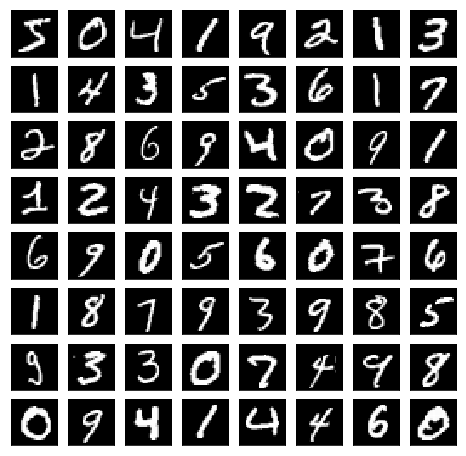

In [0]:
images = next(iter(mnist_dataset))
print(images.shape)
# Display some images from this batch for a quick confirmation
display_images(images[:64].numpy())

## Loading the Fashion MNIST dataset

In [0]:
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = tf.keras.datasets.fashion_mnist.load_data()
X_train_fashion = X_train_fashion.reshape((60000, 28, 28, 1))

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
fashion_mnist_dataset = tf.data.Dataset.from_tensor_slices(X_train_fashion)
fashion_mnist_dataset = fashion_mnist_dataset.map(normalize_images).batch(batch_size)

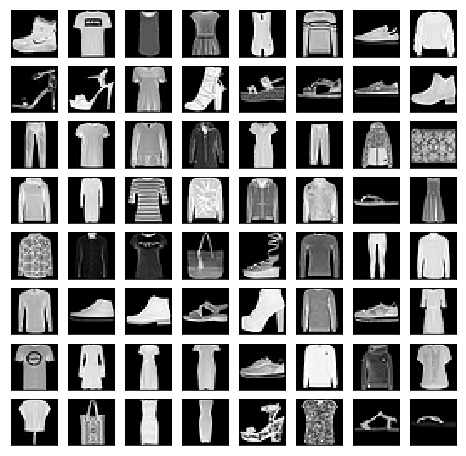

In [0]:
# visualize the fashiom mnist dataset
fashion_images = next(iter(fashion_mnist_dataset))
display_images(fashion_images[:64].numpy())

## Define the Model

These are very sensitive to the choice of hyperparameters. The main poin to note here is the usage of gradient tapes for the computation of the derivatives using the Backpropagation algo.

In [0]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.dense1 = tf.keras.layers.Dense(7 * 7 * 256, use_bias=False, kernel_initializer=tf.initializers.random_normal(stddev=0.02))
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.activation1 = tf.keras.layers.ReLU()
        self.reshape1 = tf.keras.layers.Reshape((7, 7, 256))
        
        self.deconv2 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=tf.initializers.random_normal(stddev=0.02))
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        self.activation2 = tf.keras.layers.ReLU()
                                                   
        self.deconv3 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=tf.initializers.random_normal(stddev=0.02))
        self.batch_norm3 = tf.keras.layers.BatchNormalization()
        self.activation3 = tf.keras.layers.ReLU()
        
        self.deconv4 = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation=tf.nn.sigmoid, use_bias=False, kernel_initializer=tf.initializers.random_normal(stddev=0.02))
        
    def call(self, z, training=False):
        x = self.dense1(z)
#         x = self.batch_norm1(x)
        x = self.activation1(x)
        x = self.reshape1(x)

#       Dimensions of X = (7 x 7 x 256)
        x = self.deconv2(x)
        x = self.batch_norm2(x, training=training)
        x = self.activation2(x)

#       Dimensions of X = (7 x 7 x 128)
        x = self.deconv3(x)
        x = self.batch_norm3(x, training=training)
        x = self.activation3(x)

#       Dimensions of X = (14 x 14 x 64)
        sample_output = self.deconv4(x)

#       Dimensions of output = (28 x 28 x 1)
        return sample_output

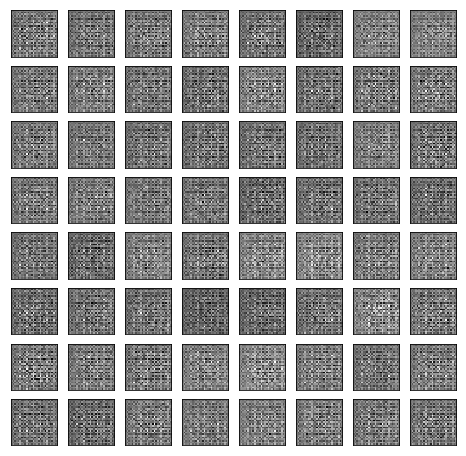

In [0]:
code_size = 100
test_samples = tf.random_normal((64, code_size), seed=0)
generator = Generator()
generated_images = generator(test_samples)
assert generated_images.shape == (64, 28, 28, 1)

# Visualize the initial images generated by the generator
# These will be mostly noise before the training has started
display_images(generated_images[:64].numpy())

In [0]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), use_bias=False, kernel_initializer=tf.initializers.random_normal(stddev=0.02))
        self.activation1 = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.dropout1 = tf.keras.layers.Dropout(0.3)
                                                   
        self.conv2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), use_bias=False, kernel_initializer=tf.initializers.random_normal(stddev=0.02))
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.activation2 = tf.keras.layers.LeakyReLU(alpha=0.2)
        self.dropout2 = tf.keras.layers.Dropout(0.3)
        
        self.flatten = tf.keras.layers.Flatten()
        self.dense3 = tf.keras.layers.Dense(1, use_bias=False, kernel_initializer=tf.initializers.random_normal(stddev=0.02))
        
    def __call__(self, sample, training=False):
#       Dimensions of sample = (28 x 28 x 1)
        x = self.conv1(sample)
#         x = self.dropout1(x, training=training)

#       Dimensions of X = (12 x 12 x 64)
        x = self.conv2(x)
        x = self.batchnorm2(x, training=training)
        x = self.activation2(x)
#         x = self.dropout2(x, training=training)
        

#       Dimensions of X = (4 x 4 x 128)
        x = self.flatten(x)
        output = self.dense3(x)

#       Dimensions of output = (1)
        return output

In [0]:
discriminator = Discriminator()
output = discriminator(generated_images)
assert output.shape == (64, 1)

## Define the loss and Gradient computation

In [0]:
def generator_loss(generator, discriminator, z_batch):
    generated_samples = generator(z_batch, training=True)
    predictions = discriminator(generated_samples, training=True)
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(predictions), predictions)

In [0]:
def discriminator_loss(generator, discriminator, z_batch, x_batch):
    real_predictions = discriminator(x_batch, training=True)
    fake_predictions = discriminator(generator(z_batch, training=True), training=True)
    real_loss = tf.losses.sigmoid_cross_entropy(tf.ones_like(real_predictions), real_predictions)
    fake_loss = tf.losses.sigmoid_cross_entropy(tf.zeros_like(fake_predictions), fake_predictions)
    
    return real_loss + fake_loss

In [0]:
generator_optim = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)
discriminator_optim = tf.train.AdamOptimizer(learning_rate=0.0002, beta1=0.5)

In [0]:
def compute_apply_disc_gradients(generator, discriminator, z, x, optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0001)):
    with tf.GradientTape() as disc_tape:
        disc_loss = discriminator_loss(generator, discriminator, z, x)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
    return disc_gradients, disc_loss

In [0]:
def compute_apply_gen_gradients(generator, discriminator, z, optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.0001)):
    with tf.GradientTape() as gen_tape:
        gen_loss = generator_loss(generator, discriminator, z)
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    return gen_gradients, gen_loss

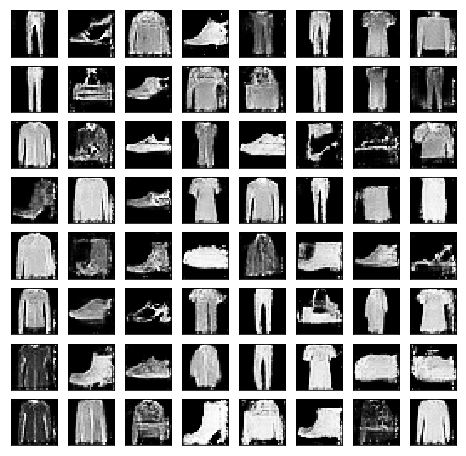

Epoch: 50 , gen_loss: 0.7163983583450317 , disc_loss: 1.387827754020691


In [0]:
generator = Generator()
discriminator = Discriminator()

numsteps = 50
k = 1
gen_loss_profile = []
disc_loss_profile = []
steprange = range(numsteps)
for step in steprange:
    count=0
    for batch in fashion_mnist_dataset:
#         Update the discriminator for k steps
        for k_idx in range(k):
            z1 = tf.random_normal((batch_size, code_size))
            _, disc_loss = compute_apply_disc_gradients(generator, discriminator, z1, batch, optimizer=discriminator_optim)
            disc_loss_profile.append(disc_loss)
#       Update the generator for a step
        z2 = tf.random_normal((batch_size, code_size))
        _, gen_loss = compute_apply_gen_gradients(generator, discriminator, z2, optimizer=generator_optim)
        gen_loss_profile.append(gen_loss)
        if count % 50 == 0:
            display.clear_output(wait=True)
            display_images(generator(test_samples).numpy())
            print(f'Epoch: {step + 1} , gen_loss: {gen_loss} , disc_loss: {disc_loss}')
        count = count + 1

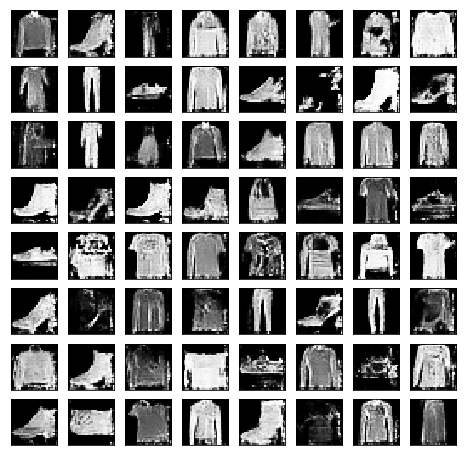

In [0]:
random_sample = tf.random_normal((64, 100))
display_images(generator(random_sample).numpy())

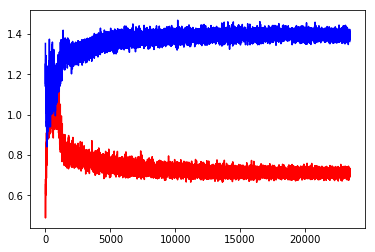

In [0]:
plt.plot(gen_loss_profile, c='r')
plt.plot(disc_loss_profile, c='b')

plt.show()